# Does amplicon bias help?
> Let's see if we should even keep this term

Using the experimental amplicon bias term introduced on Nov 29 2022

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from aptr.simulation_new import make_tables
from aptr.database import RnaDB
from aptr.torch_solver import TorchSolver

plt.rc("font", size=20)

In [3]:
rnadb = RnaDB(
    # path_to_dnaA = "../../data/allDnaA.tsv",
    # path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [4]:
# Copied from scaling_experiment_matrix.ipynb


def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances

In [6]:
# Experiment: How does the model perform with a bias term in the presence/absence of actual_bias?

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

results = pd.DataFrame(
    columns=[
        "scale",
        "simulation_bias",
        "model_bias",
        "genome",
        "sample",
        "ptr_true",
        "ptr_inferred",
        "ptr_score",
        "abundance_true",
        "abundance_inferred",
        "abundance_score",
    ]
)

for simulation_bias in [True, False]:
    for multiplier in range(-3, 3):
        scale = 10**multiplier
        print(f"Scale: {scale}")
        abundances, log2_ptrs, otus = make_tables(db=rnadb, n_samples=20, n_genomes=10, sparsity=0, multiplier=scale)
        if simulation_bias:
            otus = otus.multiply(np.random.rand(otus.shape[0]), axis=0)

        for model_bias in [True, False]:
            solver = TorchSolver(otus=otus, db=rnadb)
            solver.train(lr=0.1, clip=True, model_bias=model_bias)
            ptr_score, abundance_score, inferred_ptrs, inferred_abundances = score(
                solver=solver, true_abundances=abundances, true_log2_ptrs=log2_ptrs
            )
            for i, genome_id in enumerate(solver.genome_ids):
                for j, sample_id in enumerate(solver.sample_ids):
                    try:
                        # results = results.append({
                        results.loc[len(results)] = {
                            "scale": scale,
                            "model_bias": model_bias,
                            "genome": genome_id,
                            "sample": sample_id,
                            "ptr_true": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                            "ptr_inferred": inferred_ptrs.loc[genome_id, sample_id],
                            "ptr_score": ptr_score.loc[genome_id, sample_id],
                            "abundance_true": abundances.loc[genome_id, sample_id],
                            "abundance_inferred": inferred_abundances.loc[genome_id, sample_id],
                            "abundance_score": abundance_score.loc[genome_id, sample_id],
                        }  # , ignore_index=True)
                    except KeyError:
                        print(f"==============KeyError: {genome_id}, {sample_id}")

Scale: 0.001
Using OTU index for md5s
Initial:	 1.0547233819961548


/home/phil/mambaforge/envs/aptr/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0:	 0.28132471442222595
Epoch 1:	 0.2746523320674896
Epoch 2:	 0.30033525824546814
Epoch 3:	 0.29988840222358704
Epoch 4:	 0.29902175068855286
Epoch 5:	 0.29679450392723083
Epoch 6:	 0.37907180190086365
Epoch 7:	 0.3788169026374817
Using OTU index for md5s
Initial:	 1.0547233819961548
Epoch 0:	 0.29139915108680725
Epoch 1:	 0.2913152277469635
Epoch 2:	 0.2911647856235504
Epoch 3:	 0.2909122705459595
Epoch 4:	 0.2904873788356781
Epoch 5:	 0.28979527950286865
Epoch 6:	 0.2886429727077484
Epoch 7:	 0.286771297454834
Epoch 8:	 0.2837277948856354
Epoch 9:	 0.27909815311431885
Epoch 10:	 0.2767000198364258
Epoch 11:	 0.2767014801502228
Epoch 12:	 0.27670422196388245
Epoch 13:	 0.27670741081237793
Epoch 14:	 0.27670034766197205
Epoch 15:	 0.27669820189476013
Epoch 16:	 0.2766991853713989
Epoch 17:	 0.276710569858551
Epoch 18:	 0.27669814229011536
Epoch 19:	 0.2767033874988556
Epoch 20:	 0.27670732140541077
Epoch 21:	 0.27670446038246155
Epoch 22:	 0.27669936418533325
Epoch 23:	 0.276697

Text(0.5, 1.0, 'Biased vs. unbiased PTR error vs. scale, unbiased reads case')

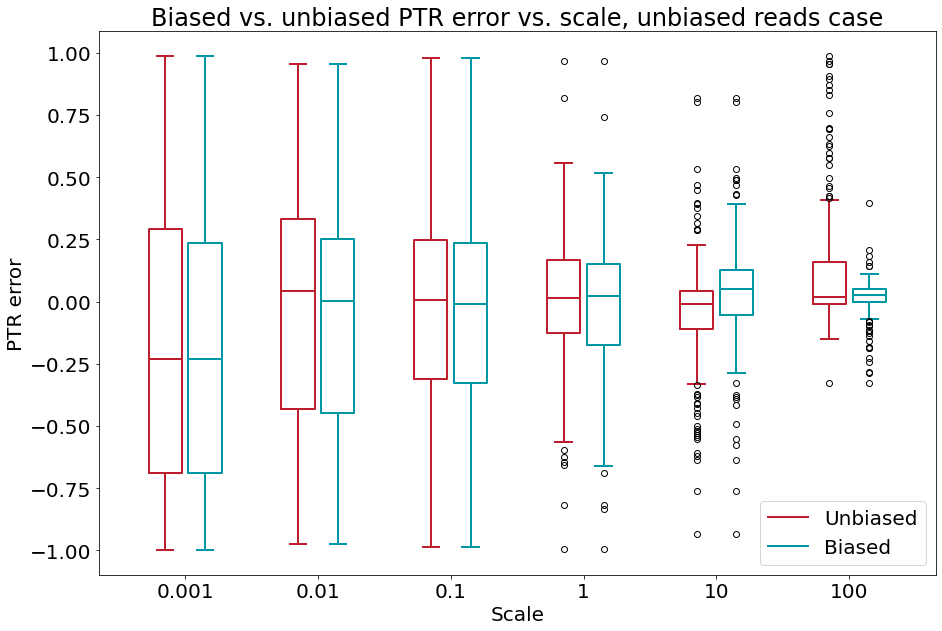

In [ ]:
fig = plt.figure(figsize=(15, 10))

# Make data
for_boxplot_unbiased = results[results["bias"] == False]
for_boxplot_bias = results[results["bias"] == True]
x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")
plt.title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"], loc="lower right")
plt.title("Biased vs. unbiased PTR error vs. scale, unbiased reads case")